In [19]:
# import dependencies
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications.resnet50 import ResNet50
from keras.applications.mobilenet import MobileNet
from keras.applications.densenet import DenseNet201
from keras.applications.inception_v3 import InceptionV3
from keras.applications.nasnet import NASNetLarge, NASNetMobile
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [16]:
# Self-defined functions
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    #IMG = []
    BIMG = []
    MIMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        
        name, ftype = os.path.splitext(PATH)
#         print(name)
        if ftype == ".png":
            img = read(PATH)
            img = cv2.resize(img, (RESIZE,RESIZE))
            if name[11:16] == 'train':
                if name[26] =='B':
                    BIMG.append(np.array(img))
                elif name[26]== 'M':
                    MIMG.append(np.array(img))
            #IMG.append(np.array(img))
            else:
                if name[25] == 'B':
                    BIMG.append(np.array(img))
                elif name[25] == 'M':
                    MIMG.append(np.array(img))
    return BIMG, MIMG

def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

### Load dataset

In [4]:
f1_b_train, f1_m_train = Dataset_loader('data/fold1/train/200X', 224)
f1_b_train = np.array(f1_b_train)
f1_m_train = np.array(f1_m_train)

f2_b_train, f2_m_train = Dataset_loader('data/fold2/train/200X', 224)
f2_b_train = np.array(f2_b_train)
f2_m_train = np.array(f2_m_train)

f3_b_train, f3_m_train = Dataset_loader('data/fold3/train/200X', 224)
f3_b_train = np.array(f3_b_train)
f3_m_train = np.array(f3_m_train)

f4_b_train, f4_m_train = Dataset_loader('data/fold4/train/200X', 224)
f4_b_train = np.array(f4_b_train)
f4_m_train = np.array(f4_m_train)

f5_b_train, f5_m_train = Dataset_loader('data/fold5/train/200X', 224)
f5_b_train = np.array(f5_b_train)
f5_m_train = np.array(f5_m_train)

100%|██████████| 1243/1243 [00:18<00:00, 67.50it/s]


In [5]:
print(f1_b_train.shape)
print(f1_m_train.shape)

(368, 224, 224, 3)
(901, 224, 224, 3)


In [6]:
f1_b_test, f1_m_test = Dataset_loader('data/fold1/test/200X', 224)
f1_b_test = np.array(f1_b_test)
f1_m_test = np.array(f1_m_test)

f2_b_test, f2_m_test = Dataset_loader('data/fold2/test/200X', 224)
f2_b_test = np.array(f2_b_test)
f2_m_test = np.array(f2_m_test)

f3_b_test, f3_m_test = Dataset_loader('data/fold3/test/200X', 224)
f3_b_test = np.array(f3_b_test)
f3_m_test = np.array(f3_m_test)

f4_b_test, f4_m_test = Dataset_loader('data/fold4/test/200X', 224)
f4_b_test = np.array(f4_b_test)
f4_m_test = np.array(f4_m_test)

f5_b_test, f5_m_test = Dataset_loader('data/fold5/test/200X', 224)
f5_b_test = np.array(f5_b_test)
f5_m_test = np.array(f5_m_test)

100%|██████████| 770/770 [00:11<00:00, 68.75it/s]


In [7]:
b_train = np.concatenate((f1_b_train, f2_b_train, f3_b_train, f4_b_train, f5_b_train), axis=0)
m_train = np.concatenate((f1_m_train, f2_m_train, f3_m_train, f4_m_train, f5_m_train), axis=0)
b_test = np.concatenate((f1_b_test, f2_b_test, f3_b_test, f4_b_test, f5_b_test), axis = 0)
m_test = np.concatenate((f1_m_test, f2_m_test, f3_m_test, f4_m_test, f5_m_test), axis = 0)
print(b_test.shape)
print(m_test.shape)

(1114, 224, 224, 3)
(2335, 224, 224, 3)


In [10]:
print(f1_b_test)

[[[[228 156 193]
   [228 142 192]
   [224 138 193]
   ...
   [200 166 196]
   [248 208 229]
   [242 204 225]]

  [[230 161 197]
   [229 143 194]
   [220 132 188]
   ...
   [235 203 226]
   [244 206 224]
   [241 205 225]]

  [[230 164 193]
   [224 138 186]
   [215 129 185]
   ...
   [239 205 229]
   [241 202 221]
   [242 207 230]]

  ...

  [[185 128 160]
   [217 142 184]
   [217 142 187]
   ...
   [217 152 188]
   [214 152 188]
   [229 182 214]]

  [[185 128 161]
   [219 147 189]
   [215 143 188]
   ...
   [208 142 180]
   [211 150 184]
   [227 177 212]]

  [[190 135 167]
   [224 156 195]
   [222 154 196]
   ...
   [205 136 178]
   [202 136 175]
   [225 174 210]]]


 [[[207 184 205]
   [193 167 208]
   [148 124 175]
   ...
   [235 209 215]
   [231 209 219]
   [232 225 228]]

  [[197 175 200]
   [207 180 225]
   [152 129 180]
   ...
   [248 232 226]
   [242 228 229]
   [225 219 219]]

  [[185 160 189]
   [197 169 216]
   [145 120 166]
   ...
   [240 228 222]
   [238 228 224]
   [228 218

### Create Label

In [8]:
b_train_label = np.zeros(len(b_train))
m_train_label = np.ones(len(m_train))
b_test_label = np.zeros(len(b_test))
m_test_label = np.ones(len(m_test))

In [9]:
# Merge data 
X_train = np.concatenate((b_train, m_train), axis = 0)
Y_train = np.concatenate((b_train_label, m_train_label), axis = 0)
X_test = np.concatenate((b_test, m_test), axis = 0)
Y_test = np.concatenate((b_test_label, m_test_label), axis = 0)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(6616, 224, 224, 3)
(6616,)
(3449, 224, 224, 3)
(3449,)


In [10]:
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

### Train and Evalutation split

In [11]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

In [15]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

### Data Generator

In [17]:
BATCH_SIZE = 16

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

### Model: ResNet50

In [20]:
K.clear_session()
gc.collect()

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

model = build_model(resnet ,lr = 1e-4)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1920)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1920)              7680      
_________________________________________________________________
dense (Dense)                (None, 2)                 3842      
Total params: 18,333,506
Trainable params: 18,100,610
Non-trainable params: 232,896
_________________________________________________________________


/Users/callter/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [21]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [23]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=2,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/2
330/330 [==============================] - 2337s 7s/step - loss: 0.3513 - accuracy: 0.8666 - val_loss: 0.1581 - val_accuracy: 0.9396
Epoch 2/2
330/330 [==============================] - 2385s 7s/step - loss: 0.2537 - accuracy: 0.9025 - val_loss: 0.2969 - val_accuracy: 0.8890


In [24]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

In [25]:
history_df = pd.DataFrame(history.history)
history_df[['acc', 'val_acc']].plot()

KeyError: "None of [Index(['acc', 'val_acc'], dtype='object')] are in the [columns]"

<AxesSubplot:>

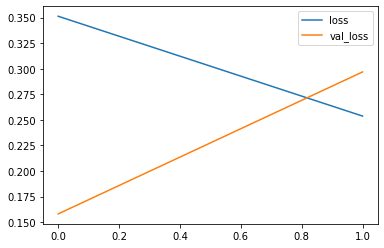

In [26]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

In [ ]:
Y_val_pred = model.predict(x_val)
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

### More Complicated version

In [13]:
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Activation

num_classes = 2
def cnn(train_X, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (5, 5), strides = (1,1), padding='same', 
                 input_shape=train_X.shape[1:]))  # 第一层需要指出图像的大小
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(1,1)))
    model.add(Conv2D(64, (5, 5), strides = (1,1)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(1,1)))
    model.add(Conv2D(128, (5, 5), strides = (1,1)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(1,1)))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    print(model.summary())

In [ ]:
import keras
model = cnn(x_train,num_classes)

    
lr=0.01
epoch = 5
opt = keras.optimizers.rmsprop(lr, decay=1e-6)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,metrics=['accuracy'])

# here we use the test_set as the validation_set    
model.fit(x_train,y_train,
          batch_size=32,
          epochs=epoch,
          verbose=1,
          validation_data=(x_val,y_val), 
          callbacks=[learn_control, checkpoint]
         )
score = model.evaluate(x_val,y_val,verbose=0)
print(score)

In [14]:
import keras
model = cnn(x_train,num_classes)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      2432      
_________________________________________________________________
activation (Activation)      (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 222, 222, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 218, 218, 64)      51264     
_________________________________________________________________
activation_1 (Activation)    (None, 218, 218, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 216, 216, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 212, 212, 128)     2